In [32]:
import matplotlib as mpl
import rebound
import reboundx
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import pandas as pd
from binary_c_API import evolve_binary

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 20
%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

# Modifying the orbital elements directly

First, we evolve a binary system using binary_c.

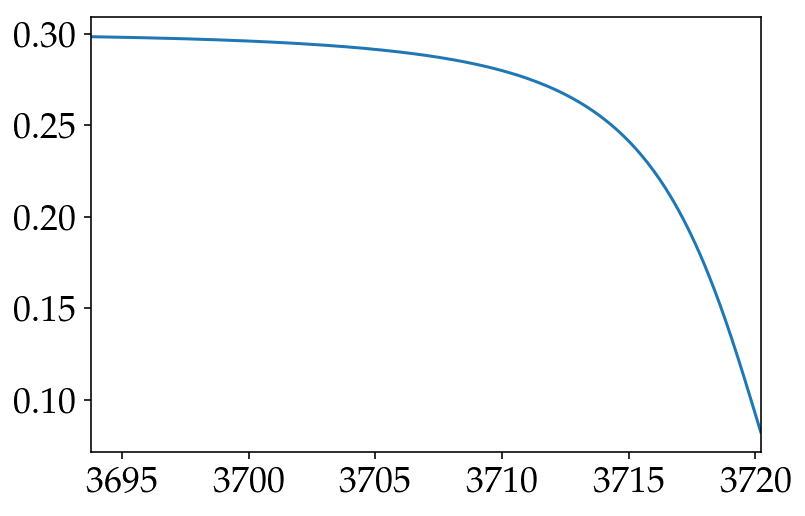

In [2]:
data = evolve_binary(13700, 1.4
                           , 0.7, 0.02,
                           200,
                           0.3)

data['e'].iloc[3900:4100].plot() 

We choose a range in time where eccentricity changes significantly. Next, we calculate the
damping timescales such that (a, e) in rebound at each binary_c timescales match the ones in
Rebound. An exponential damping timescale $\tau_a$ for say semi-major axis is given by the
following equation.

$$\frac{\dot{a}}{a}=\frac{1}{\tau_a}$$

we can integrate this differential equation easily

$$\frac{da}{a}=\frac{dt}{\tau_a}$$

the result is

$$\ln a_{i+1}-\ln a_i=\frac{t_{i+1}-t_i}{\tau_a}$$

Where $i$ denotes the value of $a$ at array position $i$. We can now solve for $\tau_a$

$$\tau_a=\frac{t_{i+1}-t_i}{\ln \frac{a_{i+1}}{a_i}}$$

Therefore, given the values of $a_i$ and $a_{i+1}$, we can always find $\tau_a$ and 
pass it to rebound, such that at time $t_{i+1}$ the value of $a$ in rebound matches the
one in binary_c.

In [3]:
i = 3900
f = 4100

a_star = data['a'].iloc[i:f].values
e_star = data['e'].iloc[i:f].values

# Define t=0 at data['t'].iloc[i] and pretend changes occur on a Kyr timescale instead
# of Myr-s
times = 2*np.pi*1e03*(data['t'].iloc[i:f].values - data['t'].iloc[i])

# Calculate e-folding timescales 
delta_t = times[1:] - times[:-1]

# Initialize simultion
sim = rebound.Simulation()

m1 = data['M1'].iloc[i]
m2 = data['M2'].iloc[i]
e_i = data['e'].iloc[i]
a_i = data['a'].iloc[i]

sim.add(m=m1)
sim.add(m=m2, a=a_i, e=e_i)
sim.move_to_com() # Moves to the center of momentum frame
ps = sim.particles

# Initilize reboundx objects
rebx = reboundx.Extras(sim)
mod_effect = rebx.add("modify_orbits_direct")

# Set the coupling parameter to 0
mod_effect.params["p"] = 0.

Nout = f - i

# Create array of times with more points between each binary_c timestep
times_dense = np.linspace(times[0], times[1], 1000)

for j in range(1, len(times) - 1):
    array = np.linspace(times[j], times[j + 1], 1000)
    times_dense = np.concatenate([times_dense, array])

Nout = len(times_dense)
a, e = np.zeros(Nout), np.zeros(Nout)

for t, time in enumerate(times_dense):
    # Update e-folding timescales every 1000 steps
    if(t % 1000 == 0):
        k = int(t/1000)
        delta_t = times[k + 1] - time
        tau_a = delta_t/np.log(a_star[k + 1]/ps[1].a)
        tau_e = delta_t/np.log(e_star[k + 1]/ps[1].e)
        ps[1].params["tau_e"] = tau_e
        ps[1].params["tau_a"] = tau_a
    
    sim.integrate(time)
    
    # Save orbital params
    e[t] = ps[1].e
    a[t] = ps[1].a

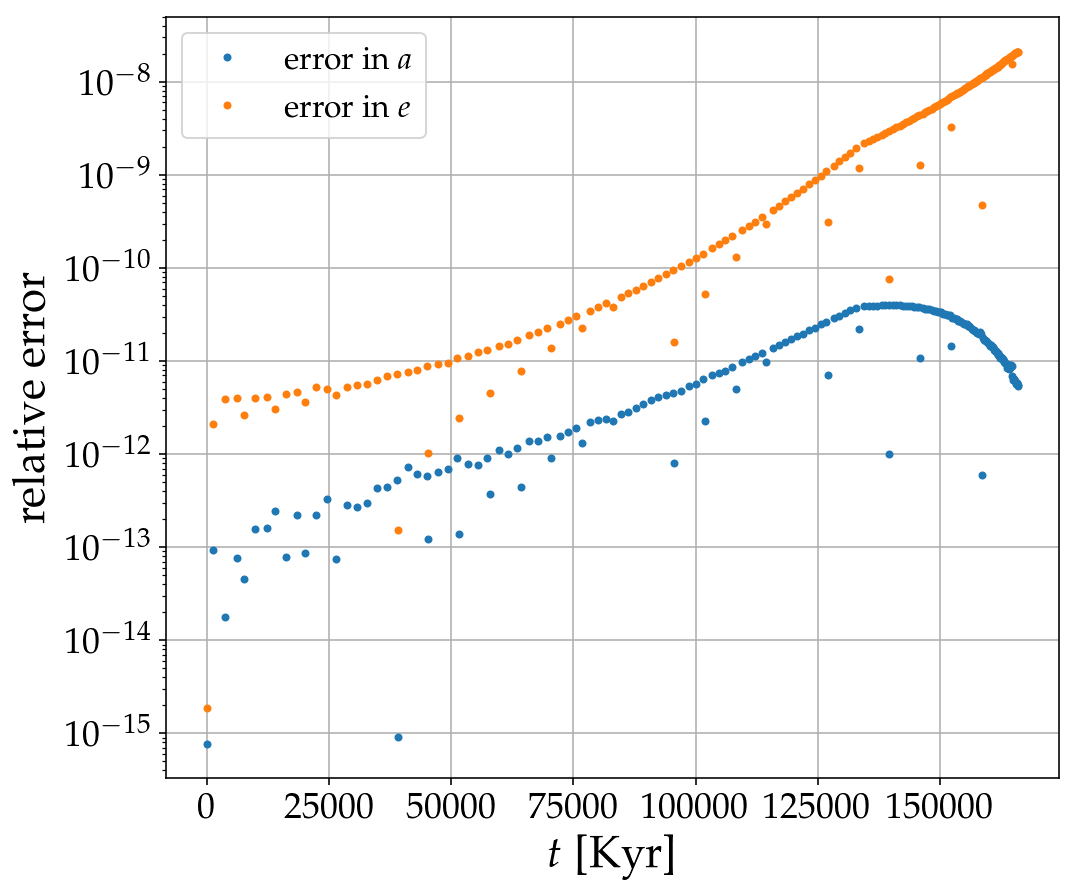

In [4]:
# Plot relative error in a and e
def plot_relative_error(ax, times, e_star, a_star):
    err_e = np.abs((e[::1000] - e_star[:-1])/e_star[:-1])
    err_a = np.abs((a[::1000] - a_star[:-1])/a_star[:-1])

    ax.semilogy(times[:-1], err_a, 'C0.', label="error in $a$")
    ax.semilogy(times[:-1], err_e, 'C1.', label="error in $e$")
    ax.legend(prop={'size': 16})
    ax.set_xlabel(r'$t$ [Kyr]')
    ax.set_ylabel('relative error')
    ax.grid(True)

fig, ax = plt.subplots(figsize=(8, 7))

plot_relative_error(ax, times, e_star, a_star)

The error in $e$ grows in time, it is unclear why.

### Behaviour in between binary_c timesteps

To check that the (a,e) is changing smoothly, we loook at rebound data between each binary_c timestep.

In [5]:
# fig, ax = plt.subplots(3, figsize=(14,15))
# for axe in ax.ravel():
#     axe.plot(times_dense/(2*np.pi*1e03), e, 'C0.', label='rebound')
#     axe.plot(times[:-1]/(2*np.pi*1e03), e_star[:-1], 'C1*', label='binary\_c')
#     axe.legend()
#     axe.set_xlabel('time [Myr]')
# ax[1].set_xlim(40.1, 40.5)
# ax[2].set_xlim(40.14, 40.15)

# Modifying orbital elements via forces

In [6]:
del sim

# Initialize simultion
sim = rebound.Simulation()

sim.add(m=m1)
sim.add(m=m2, a=a_i, e=e_i)
sim.move_to_com() # Moves to the center of momentum frame
ps = sim.particles

# Initilize reboundx objects
rebx = reboundx.Extras(sim)
mod_effect = rebx.add("modify_orbits_forces")

for t, time in enumerate(times_dense):
    # Update e-folding timescales every 1000 steps
    if(t % 1000 == 0):
        k = int(t/1000)
        delta_t = times[k + 1] - time
        tau_a = delta_t/np.log(a_star[k + 1]/ps[1].a)
        tau_e = delta_t/np.log(e_star[k + 1]/ps[1].e)
        ps[1].params["tau_e"] = tau_e
        ps[1].params["tau_a"] = tau_a
    
    sim.integrate(time)
    
    # Save orbital params
    e[t] = ps[1].e
    a[t] = ps[1].a

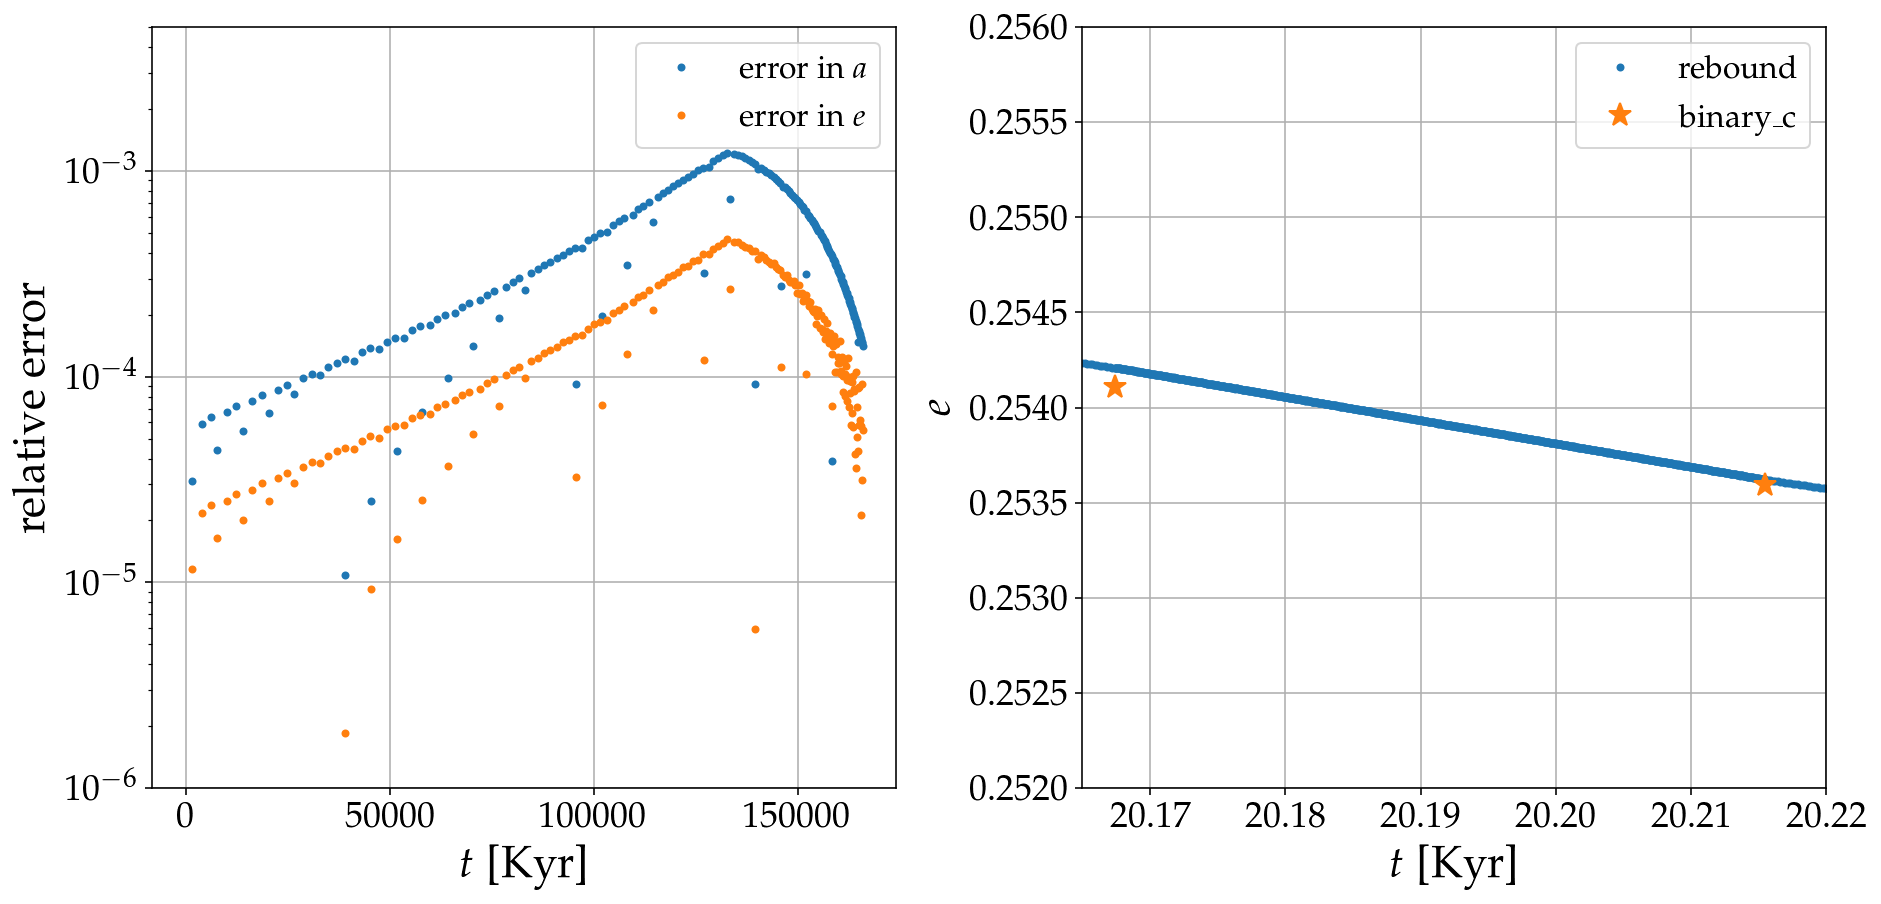

In [43]:
# Plot relative error in a and e
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.subplots_adjust(wspace=0.25)
plot_relative_error(ax[0], times, e_star, a_star)
ax[0].set_ylim(bottom=1e-06)

ax[1].plot(times_dense/(2*np.pi*1e03), e, 'C0.', label='rebound')
ax[1].plot(times[:-1]/(2*np.pi*1e03), e_star[:-1], 'C1*', label='binary\_c', 
          markersize=12)
ax[1].legend(prop={'size': 16})
ax[1].set_xlabel('$t$ [Kyr]')
ax[1].set_ylabel('$e$')
ax[1].grid(True)
ax[1].set_ylim(0.252, 0.256)
ax[1].set_xlim(20.165, 20.22)

plt.savefig('figures/stellar_evolution/rebound_binary_c_coupling.pdf', bbox_inches='tight')

With the additional forces approach, the error is very small and relatively flat in time. I'll use this approach because it's more physically motivated than changing the orbital
elements directly.

In [ ]:
fig, ax = plt.subplots(3, figsize=(14,15))
for a in ax.ravel():
    a.plot(times_dense/(2*np.pi*1e03), e, 'C0.', label='rebound')
    a.plot(times[:-1]/(2*np.pi*1e03), e_star[:-1], 'C1*', label='binary_c')
    a.legend()
    a.set_xlabel('time [thousands of years]')
# ax[1].set_xlim(40.1, 40.5)
# ax[2].set_xlim(40.14, 40.15)